# Import Libraries

In [2]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import joblib
stop_words = "english"

from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
# train test split import
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', 500)


In [ ]:
df = pd.read_csv("movies_genres.csv", delimiter='\t')

# random sample of 5 rows view
df.sample(1)

# Preprocessing

<Axes: xlabel='genre'>

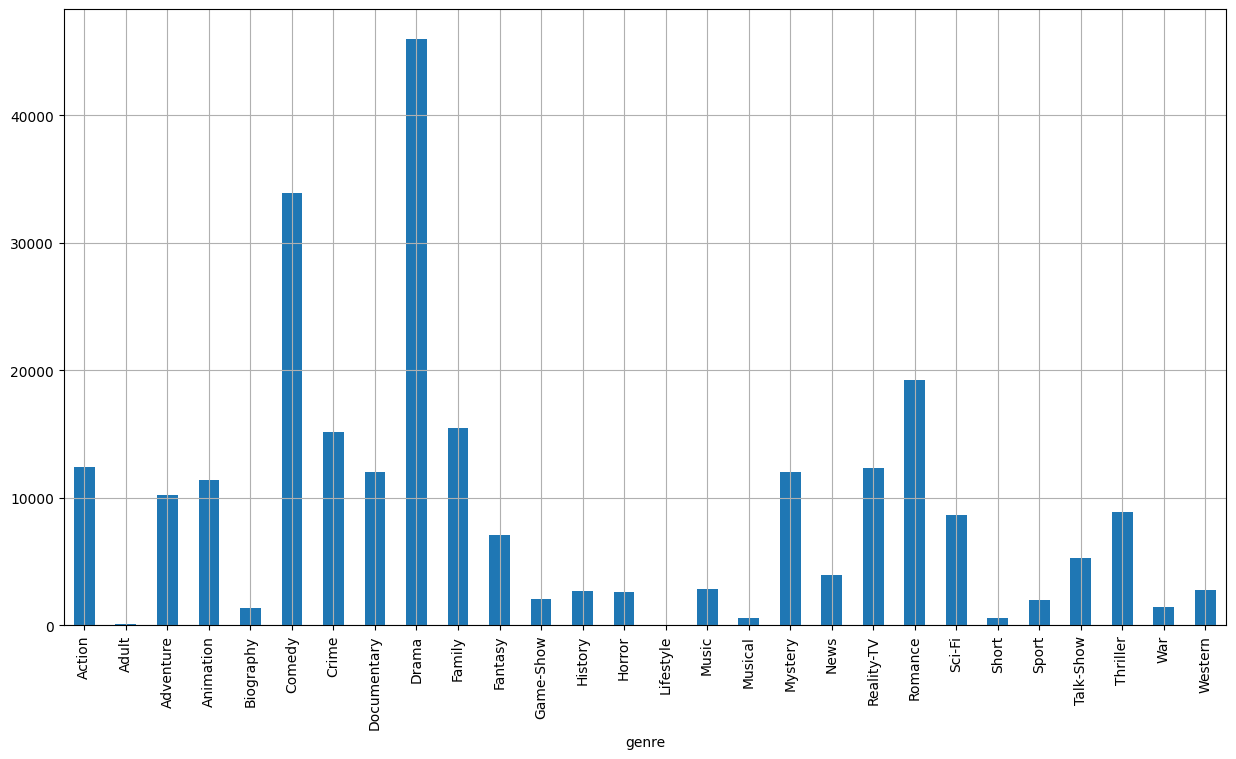

In [60]:
df_genres = df.drop(['plot', 'title'], axis=1)
counts = []
categories = list(df_genres.columns.values)
for i in categories:
    counts.append((i, df_genres[i].sum()))
df_stats = pd.DataFrame(counts, columns=['genre', '#movies'])
df_stats.plot(x='genre', y='#movies', kind='bar', legend=False, grid=True, figsize=(15, 8))

In [77]:
df_stats

,genre,#movies
0,Action,12381
1,Adult,61
2,Adventure,10245
3,Animation,11375
4,Biography,1385
5,Comedy,33875
6,Crime,15133
7,Documentary,12020
8,Drama,46017
9,Family,15442


In [61]:
# since 0 values so drop 
df.drop('Lifestyle', axis=1, inplace=True)

In [62]:
# detect plot languages
##from langdetect import detect
#df['plot_lang'] = df['plot'].apply(lambda x: detect(x))
# view all
#df['plot_lang'].value_counts()


In [65]:
# Keep only English movies
data_df = pd.read_csv("movies_genres_en.csv", delimiter='\t')
data_df = data_df[data_df['plot_lang'] == 'en']

# undummify genres create a new column with all genres
column_names = data_df.columns
one_hot_columns = data_df.columns.difference(['title', 'plot', 'plot_lang'])
data_df['Genre'] = data_df[one_hot_columns].idxmax(axis=1)
# drop one hot columns
data_df.drop(one_hot_columns, axis=1, inplace=True)

data_df.sample(1)


,title,plot,plot_lang,Genre
17755,"""ChuckleVision"" (1987) {Funny Money (#17.4)}","Well-off Uncle Richie gives Paul and Barry a wheelbarrow full of money to give away but they are pursued by another, aggrieved relation, Bob Beans Chuckle, who says the money should given to him. In the event the notes prove to be fake, apart from the ones Barry puts on a bonfire.",en,Comedy


In [66]:
# export prepared data
data_df.to_csv('data_preprocessed.csv', sep='\t', index=False)

# Modelling

In [15]:
#Load pre-processed data

data_df = pd.read_csv("data_preprocessed.csv", delimiter='\t')
# keep only 300 rows in total stratified by genre for faster training
#data_df = data_df.groupby('Genre').apply(lambda x: x.sample(n=27, random_state=42)).reset_index(drop=True)
#data_df['Genre'].value_counts(), data_df.shape


In [16]:
# split the data
# import stratified split
data_x = data_df[['plot']].values
data_y = data_df.drop(['title', 'plot', 'plot_lang'], axis=1).values
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.30, random_state=42, stratify=data_y)

# Transform matrix of plots into lists to pass to a TfidfVectorizer
train_x = [x[0].strip() for x in x_train.tolist()]
test_x = [x[0].strip() for x in x_test.tolist()]

# transform matrix of plots into lists to pass to a TfidfVectorizer
train_x = [x[0].strip() for x in x_train.tolist()]
test_x = [x[0].strip() for x in x_test.tolist()]

In [ ]:
# Stop words
stop_words = "english"  # or use a predefined list

# Define model pipelines and parameter grids
pipelines = [
    {
        'name': 'Naive Bayes',
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=stop_words)),
            ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),
        ]),
        'parameters': {
            'tfidf__max_df': (0.30, 0.5, 0.80),
            'tfidf__ngram_range': [(1, 1), (1, 3), (1, 6)],
            'clf__estimator__alpha': (1e-2, 1e-3)
        }
    },
    {
        'name': 'SVM Linear',
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=stop_words)),
            ('clf', OneVsRestClassifier(LinearSVC())),
        ]),
        'parameters': {
            'tfidf__max_df': (0.30, 0.5, 0.80),
            'tfidf__ngram_range': [(1, 1), (1, 3), (1, 6)],
            "clf__estimator__C": [0.01, 0.1, 1],
            "clf__estimator__class_weight": ['balanced', None],
        }
    },
    {
        'name': 'Logistic Regression',
        'pipeline': Pipeline([
            ('tfidf', TfidfVectorizer(stop_words=stop_words)),
            ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
        ]),
        'parameters': {
            'tfidf__max_df': (0.30, 0.5, 0.80),
            'tfidf__ngram_range': [(1, 1), (1, 3), (1, 6)],
            "clf__estimator__C": [0.01, 0.1, 1],
            "clf__estimator__class_weight": ['balanced', None],
        }
    }
]

# Define an empty list to store results
results = []

# Perform grid search and evaluate each model
for model in pipelines:
    print(f"Evaluating model: {model['name']}")
    grid_search = GridSearchCV(model['pipeline'], model['parameters'], cv=3, verbose=10, scoring='f1_macro')
    grid_search.fit(train_x, y_train)
    
    # Best parameters
    best_params = grid_search.best_estimator_.steps
    best_score = grid_search.best_score_
    
    # Measure performance on the test set
    y_pred = grid_search.predict(test_x)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    
    # Store results
    results.append({
        'Model': model['name'],
        'Best Parameters': best_params,
        'Best Cross-Validation Score': best_score,
        'Test Accuracy': accuracy,
        'Test F1 Score': f1,
        'Test Precision': precision,
        'Test Recall': recall
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

In [94]:
results_df.head(100)

,Model,Best Parameters,Best Cross-Validation Score,Test Accuracy,Test F1 Score,Test Precision,Test Recall
0,Naive Bayes,"[(tfidf, TfidfVectorizer(max_df=0.3, stop_words='english')), (clf, OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01)))]",0.307895,0.301370,0.301370,0.301370,0.301370
1,SVM Linear,"[(tfidf, TfidfVectorizer(max_df=0.3, ngram_range=(1, 6), stop_words='english')), (clf, OneVsRestClassifier(estimator=LinearSVC(C=1, class_weight='balanced')))]",0.309013,0.324201,0.324201,0.324201,0.324201
2,Logistic Regression,"[(tfidf, TfidfVectorizer(max_df=0.3, ngram_range=(1, 3), stop_words='english')), (clf, OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced',\n solver='sag')))]",0.287927,0.324201,0.324201,0.324201,0.324201


# Train the best Model and Predict on External Data

In [17]:
# Train the best model Linear SVM
best_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words, max_df=0.3, ngram_range=(1, 6))),
    ('clf', OneVsRestClassifier(LinearSVC(C=1, class_weight='balanced')))
])

best_model.fit(train_x, y_train) # Can train on whole dataset!


c:\Users\tashf\anaconda3\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.3, ngram_range=(1, 6),
                                 stop_words='english')),
                ('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=1,
                                                         class_weight='balanced')))])

In [19]:
# Save the model to disk other way
import joblib
joblib.dump(best_model, 'finalized_model.pkl')


['finalized_model.pkl']

In [3]:
# import model
best_model = joblib.load('finalized_model.pkl')


In [ ]:
# Chatbot function
def genre_prediction_chatbot():
    print("Welcome to the Genre Prediction Chatbot!")
    print("Type your plot below (or type 'exit' to quit):")
    
    while True:
        # Get user input
        input_plot = input("")
        
        # Check if the user wants to exit
        if input_plot.lower() == 'exit':
            print("Exiting chatbot. Goodbye!")
            break
        
        if len(input_plot) <= 50:
            print("Please enter a plot with more words.")
            continue
        
        # Predict the genre
        predicted_genres = best_model.predict([input_plot])
        
        # Print the predicted genres
        print("Predicted Genres: ", predicted_genres)

# Run the chatbot
genre_prediction_chatbot()

# Use Pretrained Hugging Face model Fine tune it and predict Genre from movie plot

In [3]:
#Load pre-processed data

df = pd.read_csv("data_preprocessed.csv", delimiter='\t')
#keep only 300 rows in total stratified by genre for faster training
df = df.groupby('Genre').apply(lambda x: x.sample(n=27, random_state=42)).reset_index(drop=True)
df['Genre'].value_counts(), df.shape

(Action         27
 Music          27
 War            27
 Thriller       27
 Talk-Show      27
 Sport          27
 Short          27
 Sci-Fi         27
 Romance        27
 Reality-TV     27
 News           27
 Mystery        27
 Musical        27
 Horror         27
 Adult          27
 History        27
 Game-Show      27
 Fantasy        27
 Family         27
 Drama          27
 Documentary    27
 Crime          27
 Comedy         27
 Biography      27
 Animation      27
 Adventure      27
 Western        27
 Name: Genre, dtype: int64,
 (729, 4))

In [4]:
# Convert the Genre to categorical labels
df['Genre'] = pd.Categorical(df['Genre'])
df['label'] = df['Genre'].cat.codes

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

val_df=val_df.head(3)
# Convert the DataFrame into Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [10]:




# Load the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df['label'].unique()))

# Tokenize the input data
def tokenize_function(examples):
    return tokenizer(examples['plot'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./Genre_model')
tokenizer.save_pretrained('./Genre_model')

C:\Users\tashf\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/583 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

c:\Users\tashf\anaconda3\lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 3.252197742462158, 'eval_runtime': 146.3926, 'eval_samples_per_second': 0.997, 'eval_steps_per_second': 0.068, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 3.188257932662964, 'eval_runtime': 145.3552, 'eval_samples_per_second': 1.004, 'eval_steps_per_second': 0.069, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 3.1651620864868164, 'eval_runtime': 145.5797, 'eval_samples_per_second': 1.003, 'eval_steps_per_second': 0.069, 'epoch': 3.0}
{'train_runtime': 4314.0246, 'train_samples_per_second': 0.405, 'train_steps_per_second': 0.026, 'train_loss': 3.1721447094066724, 'epoch': 3.0}


('./Genre_model\\tokenizer_config.json',
 './Genre_model\\special_tokens_map.json',
 './Genre_model\\vocab.txt',
 './Genre_model\\added_tokens.json')

In [6]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('./Genre_model')
tokenizer = DistilBertTokenizer.from_pretrained('./Genre_model')

# Create a dictionary for label mapping
label_mapping = {
    0: 'Action', 1: 'Adult', 2: 'Adventure', 3: 'Animation', 4: 'Biography',
    5: 'Comedy', 6: 'Crime', 7: 'Documentary', 8: 'Drama', 9: 'Family',
    10: 'Fantasy', 11: 'Game-Show', 12: 'History', 13: 'Horror', 14: 'Music',
    15: 'Musical', 16: 'Mystery', 17: 'News', 18: 'Reality-TV', 19: 'Romance',
    20: 'Sci-Fi', 21: 'Short', 22: 'Sport', 23: 'Talk-Show', 24: 'Thriller',
    25: 'War', 26: 'Western'
}

# Chatbot function
def genre_prediction_chatbot():
    print("Welcome to the Genre Prediction Chatbot!")
    print("Type your plot below (or type 'exit' to quit):")
    
    while True:
        # Get user input
        input_plot = input("")
        
        # Check if the user wants to exit
        if input_plot.lower() == 'exit':
            print("Exiting chatbot. Goodbye!")
            break
        
        if len(input_plot) <= 50:
            print("Please enter a plot with more words.")
            continue
        
        # Tokenize the input plot
        inputs = tokenizer(input_plot, return_tensors='pt')
        
        # Make a prediction
        with torch.no_grad():  # Disable gradient computation for inference
            outputs = model(**inputs)
            predicted_label = torch.argmax(outputs.logits, dim=1).item()
        
        # Convert the label back to the genre
        predicted_genre = label_mapping.get(predicted_label, "Unknown Genre")
        
        # Print the predicted genre
        print("Predicted Genre: ", predicted_genre,predicted_label)

# Run the chatbot
genre_prediction_chatbot()


Welcome to the Genre Prediction Chatbot!
Type your plot below (or type 'exit' to quit):
Predicted Genre:  Romance 19
Predicted Genre:  Drama 8
Predicted Genre:  Reality-TV 18
Exiting chatbot. Goodbye!


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer
from datasets import Dataset, load_metric
import torch

# Load the trained model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('./Genre_model')
tokenizer = DistilBertTokenizer.from_pretrained('./Genre_model')

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['plot'], padding='max_length', truncation=True)

val_dataset = val_dataset.map(tokenize_function, batched=True)
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Define a metric function for accuracy
metric = load_metric('accuracy', trust_remote_code=True)

def compute_metrics(p):
    # Convert predictions from logits to predicted class IDs
    predictions = torch.argmax(torch.tensor(p.predictions), dim=1).numpy()
    # Use label_ids directly since it's already a NumPy array
    references = p.label_ids
    return metric.compute(predictions=predictions, references=references)

# Initialize Trainer
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
)

# Evaluate the model on the validation dataset
eval_results = trainer.evaluate(eval_dataset=val_dataset)

# Print the evaluation results
print("Evaluation Results:", eval_results)


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

C:\Users\tashf\AppData\Local\Temp\ipykernel_12016\652260377.py:19: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy', trust_remote_code=True)
c:\Users\tashf\anaconda3\lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 2.9651052951812744, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 4.2621, 'eval_samples_per_second': 0.704, 'eval_steps_per_second': 0.235}
